In [1]:
import datetime
import json
from os.path import join

import logomaker as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyliftover
import seaborn as sns
import seqlogo
from Bio.Seq import Seq
from pyfaidx import Fasta

from all_code import (
                        calculate_chi2_p_values,
                        filter_and_convert_to_list,
                        get_context,
                        plot_p_values,
                        translate_context,
                    )

## 1. Separate variants by pathogenicity value

Create dataframes for pathogenic/benign variants based on frequency.

* **pathogenic**  
 Cutoff in AC < 2. Additionally, intersect with the options in ClinVar and add pathogenic/likely pathogenic variants that are missing in GnomAD v.4, but are in ClinVar.

* **benign**  
 AC cut-off >= 2 (according to recent ACGS guidelines, BS2 criterion). In this case, we may have many autosomal recessive variants left, so let’s remove them. To do this, compare the resulting dataframe with benign ClinVar variants and remove all intersections with registered P/LP variants.

ClinVar does not contain transcripts for the variants, so first annotate the downloaded Clinvar file (GRCh38 version) with VEP. 

In [3]:
nmd_undergo_df = pd.read_csv("data/nmd_undergo_df.csv")

In [4]:
pat_nmd_undergo = nmd_undergo_df.query('AC < 2')

In [5]:
ben_nmd_undergo = nmd_undergo_df.query('AC >= 2')

### Remove all pathogenic Clinvar variants from benign dataframe

Merge `clinvar_nmd_undergo_df` and `ben_nmd_undergo` dataframes, remove all intersections by `CHROM`, `POS`, `REF`, `ALT`, and then remove the remainder of `clinvar_nmd_undergo_df` (i.e. remove all rows that do not have an empty `CLNSIG` column).

In [6]:
clinvar_nmd_undergo_df = pd.read_csv("data/clinvar_nmd_undergo_df.csv")
clinvar_nmd_undergo = clinvar_nmd_undergo_df.rename(columns={'Feature': 'Canonical_transcript'})

In [7]:
merged_clinvar_and_ben_undergo = pd.concat([ben_nmd_undergo, clinvar_nmd_undergo], ignore_index=True)
merged_clinvar_and_ben_undergo

CHROM       POS          rsID REF ALT Impact  Consequence Gene_symbol  \
0      chr1   2025660             .   C   A   HIGH  stop_gained       GABRD   
1      chr1   2028164  rs1441225021   C   G   HIGH  stop_gained       GABRD   
2      chr1   2029236  rs1405824159   C   T   HIGH  stop_gained       GABRD   
3      chr1   2228818  rs1225111926   C   T   HIGH  stop_gained         SKI   
4      chr1   2511342             .   A   C   HIGH  stop_gained       PANK4   
...     ...       ...           ...  ..  ..    ...          ...         ...   
8899  chr22  50721740           NaN   C   T    NaN  stop_gained         NaN   
8900  chr22  50722004           NaN   G   T    NaN  stop_gained         NaN   
8901  chr22  50722235           NaN   C   T    NaN  stop_gained         NaN   
8902  chr22  50722255           NaN   G   A    NaN  stop_gained         NaN   
8903  chr22  50722340           NaN   C   T    NaN  stop_gained         NaN   

     Canonical_transcript  cDNA_position  ...         ID  \
0         ENST00000378585            471  ...        NaN   
1         ENST00000378585            642  ...        NaN   
2         ENST00000378585            896  ...        NaN   
3         ENST00000378536            500  ...        NaN   
4         ENST00000378466           1838  ...        NaN   
...                   ...            ...  ...        ...   
8899      ENST00000262795           3958  ...   545051.0   
8900      ENST00000262795           4222  ...  2663911.0   
8901      ENST00000262795           4453  ...   422407.0   
8902      ENST00000262795           4473  ...  1675899.0   
8903      ENST00000262795           4558  ...  1177294.0   

                            CLNSIG                      CLNVC      GENEINFO  \
0                              NaN                        NaN           NaN   
1                              NaN                        NaN           NaN   
2                              NaN                        NaN           NaN   
3                              NaN                        NaN           NaN   
4                              NaN                        NaN           NaN   
...                            ...                        ...           ...   
8899                    Pathogenic  single_nucleotide_variant  SHANK3:85358   
8900                    Pathogenic  single_nucleotide_variant  SHANK3:85358   
8901  Pathogenic/Likely_pathogenic  single_nucleotide_variant  SHANK3:85358   
8902                    Pathogenic  single_nucleotide_variant  SHANK3:85358   
8903             Likely_pathogenic  single_nucleotide_variant  SHANK3:85358   

                       MC  SYMBOL             Gene  Feature_type  \
0                     NaN     NaN              NaN           NaN   
1                     NaN     NaN              NaN           NaN   
2                     NaN     NaN              NaN           NaN   
3                     NaN     NaN              NaN           NaN   
4                     NaN     NaN              NaN           NaN   
...                   ...     ...              ...           ...   
8899  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8900  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8901  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8902  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8903  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   

             BIOTYPE CANONICAL  
0                NaN       NaN  
1                NaN       NaN  
2                NaN       NaN  
3                NaN       NaN  
4                NaN       NaN  
...              ...       ...  
8899  protein_coding       YES  
8900  protein_coding       YES  
8901  protein_coding       YES  
8902  protein_coding       YES  
8903  protein_coding       YES  

[8904 rows x 27 columns]

In [8]:
# remove duplicates
ben_nmd_undergo_filtered = merged_clinvar_and_ben_undergo.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_nmd_undergo_filtered

CHROM       POS          rsID REF ALT Impact  Consequence Gene_symbol  \
0      chr1   2025660             .   C   A   HIGH  stop_gained       GABRD   
1      chr1   2028164  rs1441225021   C   G   HIGH  stop_gained       GABRD   
2      chr1   2029236  rs1405824159   C   T   HIGH  stop_gained       GABRD   
3      chr1   2228818  rs1225111926   C   T   HIGH  stop_gained         SKI   
4      chr1   2511342             .   A   C   HIGH  stop_gained       PANK4   
...     ...       ...           ...  ..  ..    ...          ...         ...   
8899  chr22  50721740           NaN   C   T    NaN  stop_gained         NaN   
8900  chr22  50722004           NaN   G   T    NaN  stop_gained         NaN   
8901  chr22  50722235           NaN   C   T    NaN  stop_gained         NaN   
8902  chr22  50722255           NaN   G   A    NaN  stop_gained         NaN   
8903  chr22  50722340           NaN   C   T    NaN  stop_gained         NaN   

     Canonical_transcript  cDNA_position  ...         ID  \
0         ENST00000378585            471  ...        NaN   
1         ENST00000378585            642  ...        NaN   
2         ENST00000378585            896  ...        NaN   
3         ENST00000378536            500  ...        NaN   
4         ENST00000378466           1838  ...        NaN   
...                   ...            ...  ...        ...   
8899      ENST00000262795           3958  ...   545051.0   
8900      ENST00000262795           4222  ...  2663911.0   
8901      ENST00000262795           4453  ...   422407.0   
8902      ENST00000262795           4473  ...  1675899.0   
8903      ENST00000262795           4558  ...  1177294.0   

                            CLNSIG                      CLNVC      GENEINFO  \
0                              NaN                        NaN           NaN   
1                              NaN                        NaN           NaN   
2                              NaN                        NaN           NaN   
3                              NaN                        NaN           NaN   
4                              NaN                        NaN           NaN   
...                            ...                        ...           ...   
8899                    Pathogenic  single_nucleotide_variant  SHANK3:85358   
8900                    Pathogenic  single_nucleotide_variant  SHANK3:85358   
8901  Pathogenic/Likely_pathogenic  single_nucleotide_variant  SHANK3:85358   
8902                    Pathogenic  single_nucleotide_variant  SHANK3:85358   
8903             Likely_pathogenic  single_nucleotide_variant  SHANK3:85358   

                       MC  SYMBOL             Gene  Feature_type  \
0                     NaN     NaN              NaN           NaN   
1                     NaN     NaN              NaN           NaN   
2                     NaN     NaN              NaN           NaN   
3                     NaN     NaN              NaN           NaN   
4                     NaN     NaN              NaN           NaN   
...                   ...     ...              ...           ...   
8899  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8900  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8901  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8902  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   
8903  SO:0001587|nonsense  SHANK3  ENSG00000251322    Transcript   

             BIOTYPE CANONICAL  
0                NaN       NaN  
1                NaN       NaN  
2                NaN       NaN  
3                NaN       NaN  
4                NaN       NaN  
...              ...       ...  
8899  protein_coding       YES  
8900  protein_coding       YES  
8901  protein_coding       YES  
8902  protein_coding       YES  
8903  protein_coding       YES  

[8462 rows x 27 columns]

In [9]:
# remove the Clinvar df
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[~ben_nmd_undergo_filtered['CLNSIG'].notna()]
ben_nmd_undergo_filtered

CHROM       POS          rsID REF ALT Impact  Consequence Gene_symbol  \
0      chr1   2025660             .   C   A   HIGH  stop_gained       GABRD   
1      chr1   2028164  rs1441225021   C   G   HIGH  stop_gained       GABRD   
2      chr1   2029236  rs1405824159   C   T   HIGH  stop_gained       GABRD   
3      chr1   2228818  rs1225111926   C   T   HIGH  stop_gained         SKI   
4      chr1   2511342             .   A   C   HIGH  stop_gained       PANK4   
...     ...       ...           ...  ..  ..    ...          ...         ...   
3473  chr22  50600868             .   C   A   HIGH  stop_gained    MAPK8IP2   
3474  chr22  50720238             .   C   A   HIGH  stop_gained      SHANK3   
3475  chr22  50720534             .   G   T   HIGH  stop_gained      SHANK3   
3476  chr22  50721521             .   G   T   HIGH  stop_gained      SHANK3   
3477  chr22  50721995             .   G   T   HIGH  stop_gained      SHANK3   

     Canonical_transcript  cDNA_position  ...  ID  CLNSIG  CLNVC  GENEINFO  \
0         ENST00000378585            471  ... NaN     NaN    NaN       NaN   
1         ENST00000378585            642  ... NaN     NaN    NaN       NaN   
2         ENST00000378585            896  ... NaN     NaN    NaN       NaN   
3         ENST00000378536            500  ... NaN     NaN    NaN       NaN   
4         ENST00000378466           1838  ... NaN     NaN    NaN       NaN   
...                   ...            ...  ...  ..     ...    ...       ...   
3473      ENST00000329492             76  ... NaN     NaN    NaN       NaN   
3474      ENST00000262795           2456  ... NaN     NaN    NaN       NaN   
3475      ENST00000262795           2752  ... NaN     NaN    NaN       NaN   
3476      ENST00000262795           3739  ... NaN     NaN    NaN       NaN   
3477      ENST00000262795           4213  ... NaN     NaN    NaN       NaN   

       MC  SYMBOL Gene  Feature_type BIOTYPE CANONICAL  
0     NaN     NaN  NaN           NaN     NaN       NaN  
1     NaN     NaN  NaN           NaN     NaN       NaN  
2     NaN     NaN  NaN           NaN     NaN       NaN  
3     NaN     NaN  NaN           NaN     NaN       NaN  
4     NaN     NaN  NaN           NaN     NaN       NaN  
...   ...     ...  ...           ...     ...       ...  
3473  NaN     NaN  NaN           NaN     NaN       NaN  
3474  NaN     NaN  NaN           NaN     NaN       NaN  
3475  NaN     NaN  NaN           NaN     NaN       NaN  
3476  NaN     NaN  NaN           NaN     NaN       NaN  
3477  NaN     NaN  NaN           NaN     NaN       NaN  

[3257 rows x 27 columns]

In [10]:
ben_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type',
       'BIOTYPE', 'CANONICAL'],
      dtype='object')

Remove unnecessary columns left after Clinvar.

In [11]:
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_undergo_filtered

CHROM       POS          rsID REF ALT Impact  Consequence Gene_symbol  \
0      chr1   2025660             .   C   A   HIGH  stop_gained       GABRD   
1      chr1   2028164  rs1441225021   C   G   HIGH  stop_gained       GABRD   
2      chr1   2029236  rs1405824159   C   T   HIGH  stop_gained       GABRD   
3      chr1   2228818  rs1225111926   C   T   HIGH  stop_gained         SKI   
4      chr1   2511342             .   A   C   HIGH  stop_gained       PANK4   
...     ...       ...           ...  ..  ..    ...          ...         ...   
3473  chr22  50600868             .   C   A   HIGH  stop_gained    MAPK8IP2   
3474  chr22  50720238             .   C   A   HIGH  stop_gained      SHANK3   
3475  chr22  50720534             .   G   T   HIGH  stop_gained      SHANK3   
3476  chr22  50721521             .   G   T   HIGH  stop_gained      SHANK3   
3477  chr22  50721995             .   G   T   HIGH  stop_gained      SHANK3   

     Canonical_transcript  cDNA_position LoF  LoF_flag  LoF_filter   AC  \
0         ENST00000378585            471  HC       NaN         NaN  2.0   
1         ENST00000378585            642  HC       NaN         NaN  3.0   
2         ENST00000378585            896  HC       NaN         NaN  5.0   
3         ENST00000378536            500  HC       NaN         NaN  2.0   
4         ENST00000378466           1838  HC       NaN         NaN  2.0   
...                   ...            ...  ..       ...         ...  ...   
3473      ENST00000329492             76  HC       NaN         NaN  2.0   
3474      ENST00000262795           2456  HC       NaN         NaN  3.0   
3475      ENST00000262795           2752  HC       NaN         NaN  2.0   
3476      ENST00000262795           3739  HC       NaN         NaN  5.0   
3477      ENST00000262795           4213  HC       NaN         NaN  2.0   

      LOEUF      pext NMD_escape  
0     0.245  1.000000         NO  
1     0.245  1.000000         NO  
2     0.245  1.000000         NO  
3     0.194  0.950938         NO  
4     0.304  0.694764         NO  
...     ...       ...        ...  
3473  0.100  0.775794         NO  
3474  0.123  1.000000         NO  
3475  0.123  1.000000         NO  
3476  0.123  1.000000         NO  
3477  0.123  1.000000         NO  

[3257 rows x 17 columns]

Before filtering:

In [12]:
ben_nmd_undergo.shape

(3478, 17)

Add position in codon for each variant.

In [13]:
ben_nmd_undergo_filtered['cDNA_position'] = ben_nmd_undergo_filtered['cDNA_position'].astype(int)

ben_nmd_undergo_filtered['Codon_position'] = np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

ben_nmd_undergo_filtered

CHROM       POS          rsID REF ALT Impact  Consequence Gene_symbol  \
0      chr1   2025660             .   C   A   HIGH  stop_gained       GABRD   
1      chr1   2028164  rs1441225021   C   G   HIGH  stop_gained       GABRD   
2      chr1   2029236  rs1405824159   C   T   HIGH  stop_gained       GABRD   
3      chr1   2228818  rs1225111926   C   T   HIGH  stop_gained         SKI   
4      chr1   2511342             .   A   C   HIGH  stop_gained       PANK4   
...     ...       ...           ...  ..  ..    ...          ...         ...   
3473  chr22  50600868             .   C   A   HIGH  stop_gained    MAPK8IP2   
3474  chr22  50720238             .   C   A   HIGH  stop_gained      SHANK3   
3475  chr22  50720534             .   G   T   HIGH  stop_gained      SHANK3   
3476  chr22  50721521             .   G   T   HIGH  stop_gained      SHANK3   
3477  chr22  50721995             .   G   T   HIGH  stop_gained      SHANK3   

     Canonical_transcript  cDNA_position LoF  LoF_flag  LoF_filter   AC  \
0         ENST00000378585            471  HC       NaN         NaN  2.0   
1         ENST00000378585            642  HC       NaN         NaN  3.0   
2         ENST00000378585            896  HC       NaN         NaN  5.0   
3         ENST00000378536            500  HC       NaN         NaN  2.0   
4         ENST00000378466           1838  HC       NaN         NaN  2.0   
...                   ...            ...  ..       ...         ...  ...   
3473      ENST00000329492             76  HC       NaN         NaN  2.0   
3474      ENST00000262795           2456  HC       NaN         NaN  3.0   
3475      ENST00000262795           2752  HC       NaN         NaN  2.0   
3476      ENST00000262795           3739  HC       NaN         NaN  5.0   
3477      ENST00000262795           4213  HC       NaN         NaN  2.0   

      LOEUF      pext NMD_escape  Codon_position  
0     0.245  1.000000         NO               3  
1     0.245  1.000000         NO               3  
2     0.245  1.000000         NO               2  
3     0.194  0.950938         NO               2  
4     0.304  0.694764         NO               2  
...     ...       ...        ...             ...  
3473  0.100  0.775794         NO               1  
3474  0.123  1.000000         NO               2  
3475  0.123  1.000000         NO               1  
3476  0.123  1.000000         NO               1  
3477  0.123  1.000000         NO               1  

[3257 rows x 18 columns]

**The dataframe with benign variants is ready.**

### Add all non-population pathogenic Clinvar variants to the pathogenic dataframe

Now add to `pat_nmd_undergo` variants that are P/LP according to ClinVar and are not found in the GnomAD v4 database.

In [14]:
pat_nmd_undergo.shape[0] + clinvar_nmd_undergo.shape[0]

15827

In [15]:
merged_clinvar_and_pat = pat_nmd_undergo.merge(clinvar_nmd_undergo, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

CHROM        POS         rsID REF ALT Impact Consequence_x Gene_symbol  \
0      chr1    1790454          NaN   G   A    NaN           NaN         NaN   
1      chr1    1825438  rs867938404   G   A   HIGH   stop_gained        GNB1   
2      chr1    2024966            .   C   A   HIGH   stop_gained       GABRD   
3      chr1    2024966            .   C   G   HIGH   stop_gained       GABRD   
4      chr1    2024993            .   G   A   HIGH   stop_gained       GABRD   
...     ...        ...          ...  ..  ..    ...           ...         ...   
15489  chr9  138120696          NaN   C   T    NaN           NaN         NaN   
15490  chr9  138120738            .   C   T   HIGH   stop_gained     CACNA1B   
15491  chr9  138120765            .   C   T   HIGH   stop_gained     CACNA1B   
15492  chr9  138120776            .   C   A   HIGH   stop_gained     CACNA1B   
15493  chr9  138120782  rs201782791   C   A   HIGH   stop_gained     CACNA1B   

      Canonical_transcript_x  cDNA_position_x  ...             Gene  \
0                        NaN              NaN  ...  ENSG00000078369   
1            ENST00000378609            379.0  ...              NaN   
2            ENST00000378585            172.0  ...              NaN   
3            ENST00000378585            172.0  ...              NaN   
4            ENST00000378585            199.0  ...              NaN   
...                      ...              ...  ...              ...   
15489                    NaN              NaN  ...  ENSG00000148408   
15490        ENST00000371372           6498.0  ...              NaN   
15491        ENST00000371372           6525.0  ...              NaN   
15492        ENST00000371372           6536.0  ...              NaN   
15493        ENST00000371372           6542.0  ...              NaN   

       Feature_type  Canonical_transcript_y         BIOTYPE  cDNA_position_y  \
0        Transcript         ENST00000378609  protein_coding           1003.0   
1               NaN                     NaN             NaN              NaN   
2               NaN                     NaN             NaN              NaN   
3               NaN                     NaN             NaN              NaN   
4               NaN                     NaN             NaN              NaN   
...             ...                     ...             ...              ...   
15489    Transcript         ENST00000371372  protein_coding           6456.0   
15490           NaN                     NaN             NaN              NaN   
15491           NaN                     NaN             NaN              NaN   
15492           NaN                     NaN             NaN              NaN   
15493           NaN                     NaN             NaN              NaN   

       CANONICAL LOEUF_y    pext_y NMD_escape_y      _merge  
0            YES   0.145  0.951698           NO  right_only  
1            NaN     NaN       NaN          NaN   left_only  
2            NaN     NaN       NaN          NaN   left_only  
3            NaN     NaN       NaN          NaN   left_only  
4            NaN     NaN       NaN          NaN   left_only  
...          ...     ...       ...          ...         ...  
15489        YES   0.240  0.976450           NO  right_only  
15490        NaN     NaN       NaN          NaN   left_only  
15491        NaN     NaN       NaN          NaN   left_only  
15492        NaN     NaN       NaN          NaN   left_only  
15493        NaN     NaN       NaN          NaN   left_only  

[15494 rows x 34 columns]

In [16]:
pat_nmd_undergo_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)

In [17]:
duplicates = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

Empty DataFrame
Columns: [CHROM, POS, rsID, REF, ALT, Impact, Consequence_x, Gene_symbol, Canonical_transcript_x, cDNA_position_x, LoF, LoF_flag, LoF_filter, AC, LOEUF_x, pext_x, NMD_escape_x, ID, CLNSIG, CLNVC, GENEINFO, MC, Consequence_y, SYMBOL, Gene, Feature_type, Canonical_transcript_y, BIOTYPE, cDNA_position_y, CANONICAL, LOEUF_y, pext_y, NMD_escape_y, _merge]
Index: []

[0 rows x 34 columns]

In [18]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [19]:
pat_nmd_undergo_filtered['Canonical_transcript_x'] = pat_nmd_undergo_filtered['Canonical_transcript_x'].fillna(pat_nmd_undergo_filtered['Canonical_transcript_y'])
pat_nmd_undergo_filtered['cDNA_position_x'] = pat_nmd_undergo_filtered['cDNA_position_x'].fillna(pat_nmd_undergo_filtered['cDNA_position_y'])
pat_nmd_undergo_filtered['Consequence_x'] = pat_nmd_undergo_filtered['Consequence_x'].fillna(pat_nmd_undergo_filtered['Consequence_y'])
pat_nmd_undergo_filtered['LOEUF_x'] = pat_nmd_undergo_filtered['LOEUF_x'].fillna(pat_nmd_undergo_filtered['LOEUF_y'])
pat_nmd_undergo_filtered['Gene_symbol'] = pat_nmd_undergo_filtered['Gene_symbol'].fillna(pat_nmd_undergo_filtered['SYMBOL'])
pat_nmd_undergo_filtered['NMD_escape_x'] = pat_nmd_undergo_filtered['NMD_escape_x'].fillna(pat_nmd_undergo_filtered['NMD_escape_y'])
pat_nmd_undergo_filtered['pext_x'] = pat_nmd_undergo_filtered['pext_x'].fillna(pat_nmd_undergo_filtered['pext_y'])

In [20]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [21]:
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y', 'pext_y'])

pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence', 'LOEUF_x': 'LOEUF', 
                                                  'NMD_escape_x':'NMD_escape', 'pext_x': 'pext'})
pat_nmd_undergo_filtered

CHROM        POS         rsID REF ALT Impact  Consequence Gene_symbol  \
0      chr1    1790454          NaN   G   A    NaN  stop_gained        GNB1   
1      chr1    1825438  rs867938404   G   A   HIGH  stop_gained        GNB1   
2      chr1    2024966            .   C   A   HIGH  stop_gained       GABRD   
3      chr1    2024966            .   C   G   HIGH  stop_gained       GABRD   
4      chr1    2024993            .   G   A   HIGH  stop_gained       GABRD   
...     ...        ...          ...  ..  ..    ...          ...         ...   
15489  chr9  138120696          NaN   C   T    NaN  stop_gained     CACNA1B   
15490  chr9  138120738            .   C   T   HIGH  stop_gained     CACNA1B   
15491  chr9  138120765            .   C   T   HIGH  stop_gained     CACNA1B   
15492  chr9  138120776            .   C   A   HIGH  stop_gained     CACNA1B   
15493  chr9  138120782  rs201782791   C   A   HIGH  stop_gained     CACNA1B   

      Canonical_transcript  cDNA_position  LoF  LoF_flag  LoF_filter   AC  \
0          ENST00000378609         1003.0  NaN       NaN         NaN  NaN   
1          ENST00000378609          379.0   HC       NaN         NaN  1.0   
2          ENST00000378585          172.0   HC       NaN         NaN  1.0   
3          ENST00000378585          172.0   HC       NaN         NaN  1.0   
4          ENST00000378585          199.0   HC       NaN         NaN  1.0   
...                    ...            ...  ...       ...         ...  ...   
15489      ENST00000371372         6456.0  NaN       NaN         NaN  NaN   
15490      ENST00000371372         6498.0   HC       NaN         NaN  1.0   
15491      ENST00000371372         6525.0   HC       NaN         NaN  1.0   
15492      ENST00000371372         6536.0   HC       NaN         NaN  1.0   
15493      ENST00000371372         6542.0   HC       NaN         NaN  1.0   

       LOEUF      pext NMD_escape  
0      0.145  0.951698         NO  
1      0.145  0.966547         NO  
2      0.245  1.000000         NO  
3      0.245  1.000000         NO  
4      0.245  1.000000         NO  
...      ...       ...        ...  
15489  0.240  0.976450         NO  
15490  0.240  0.976450         NO  
15491  0.240  0.976450         NO  
15492  0.240  0.976450         NO  
15493  0.240  0.976450         NO  

[15494 rows x 17 columns]

In [22]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape'],
      dtype='object')

Before adding Clinvar variants:

In [23]:
pat_nmd_undergo.shape

(10401, 17)

Add position in codon for each variant.

In [24]:
pat_nmd_undergo_filtered['cDNA_position'] = pat_nmd_undergo_filtered['cDNA_position'].astype(int)

pat_nmd_undergo_filtered['Codon_position'] = np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

pat_nmd_undergo_filtered

CHROM        POS         rsID REF ALT Impact  Consequence Gene_symbol  \
0      chr1    1790454          NaN   G   A    NaN  stop_gained        GNB1   
1      chr1    1825438  rs867938404   G   A   HIGH  stop_gained        GNB1   
2      chr1    2024966            .   C   A   HIGH  stop_gained       GABRD   
3      chr1    2024966            .   C   G   HIGH  stop_gained       GABRD   
4      chr1    2024993            .   G   A   HIGH  stop_gained       GABRD   
...     ...        ...          ...  ..  ..    ...          ...         ...   
15489  chr9  138120696          NaN   C   T    NaN  stop_gained     CACNA1B   
15490  chr9  138120738            .   C   T   HIGH  stop_gained     CACNA1B   
15491  chr9  138120765            .   C   T   HIGH  stop_gained     CACNA1B   
15492  chr9  138120776            .   C   A   HIGH  stop_gained     CACNA1B   
15493  chr9  138120782  rs201782791   C   A   HIGH  stop_gained     CACNA1B   

      Canonical_transcript  cDNA_position  LoF  LoF_flag  LoF_filter   AC  \
0          ENST00000378609           1003  NaN       NaN         NaN  NaN   
1          ENST00000378609            379   HC       NaN         NaN  1.0   
2          ENST00000378585            172   HC       NaN         NaN  1.0   
3          ENST00000378585            172   HC       NaN         NaN  1.0   
4          ENST00000378585            199   HC       NaN         NaN  1.0   
...                    ...            ...  ...       ...         ...  ...   
15489      ENST00000371372           6456  NaN       NaN         NaN  NaN   
15490      ENST00000371372           6498   HC       NaN         NaN  1.0   
15491      ENST00000371372           6525   HC       NaN         NaN  1.0   
15492      ENST00000371372           6536   HC       NaN         NaN  1.0   
15493      ENST00000371372           6542   HC       NaN         NaN  1.0   

       LOEUF      pext NMD_escape  Codon_position  
0      0.145  0.951698         NO               1  
1      0.145  0.966547         NO               1  
2      0.245  1.000000         NO               1  
3      0.245  1.000000         NO               1  
4      0.245  1.000000         NO               1  
...      ...       ...        ...             ...  
15489  0.240  0.976450         NO               3  
15490  0.240  0.976450         NO               3  
15491  0.240  0.976450         NO               3  
15492  0.240  0.976450         NO               2  
15493  0.240  0.976450         NO               2  

[15494 rows x 18 columns]

**The dataframe with pathogenic variants is ready.**

## 3. Balance dataframes

In both dataframes, we will leave only those genes that are found in both `ben_nmd_undergo_filtered` and `pat_nmd_undergo_filtered`, and also equalize the number of variants in each gene.

In [25]:
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))


Unique genes in pat dataframe: 1415
Unique genes in ben dataframe: 917
Intersected genes: 900


In [26]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]

In [27]:
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))

Unique genes in pat dataframe: 900
Unique genes in ben dataframe: 900
Intersected genes: 900


In [28]:
count_pat = pat_nmd_undergo_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_undergo_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_undergo_final = pd.concat([
    pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_undergo_final = pd.concat([
    ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [29]:
pat_nmd_undergo_final.shape == ben_nmd_undergo_final.shape

True

In [30]:
pat_nmd_undergo_final['Gene_symbol'].nunique() == ben_nmd_undergo_final['Gene_symbol'].nunique()

True

In [31]:
pat_nmd_undergo_final['Gene_symbol'].value_counts().sum() == ben_nmd_undergo_final['Gene_symbol'].value_counts().sum()

True

In [32]:
pat_nmd_undergo_final['Gene_symbol'].nunique()

900

Dataframes are now balanced by genes and number of variants.

## 4. Visualize the distribution of cDNA positions relative to the start and end of transcripts

Get a dictionary with transcript lengths and write the % location of the variant into a dataframe.

In [33]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

In [34]:
transcript_lengths = {}
for key in transcript_fasta.keys():
    transcript_lengths[key] = len(transcript_fasta[key])

In [35]:
def get_cdna_percentage(row):
    transcript = row['Canonical_transcript']
    if transcript in transcript_lengths:
        return (row['cDNA_position'] / transcript_lengths[transcript]) * 100
    return None

In [36]:
pat_nmd_undergo_final['Percent_position'] = pat_nmd_undergo_final.apply(get_cdna_percentage, axis=1)
ben_nmd_undergo_final['Percent_position'] = ben_nmd_undergo_final.apply(get_cdna_percentage, axis=1)

Visualize the distribution of variants.

In [37]:
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final.copy()
pat_nmd_undergo_final_sorted['CHROM'] = pat_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

In [38]:
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final.copy()
ben_nmd_undergo_final_sorted['CHROM'] = ben_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

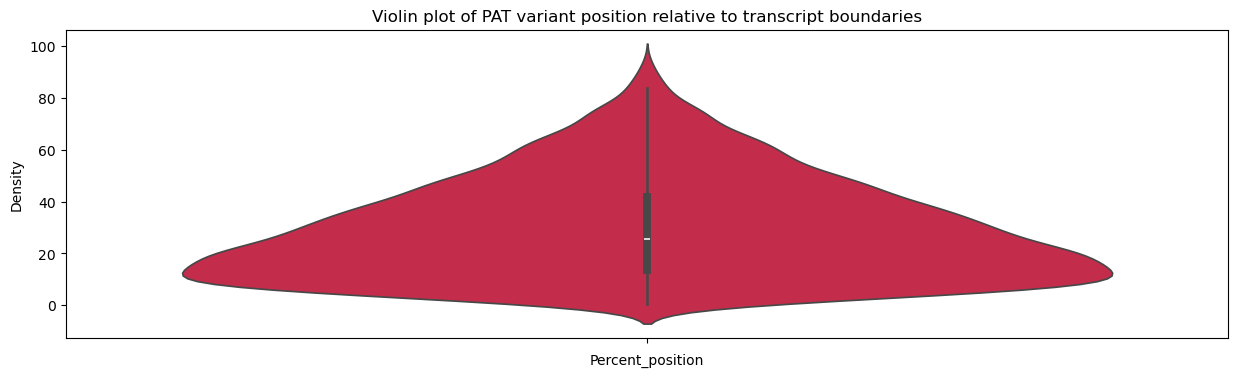

In [39]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=pat_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

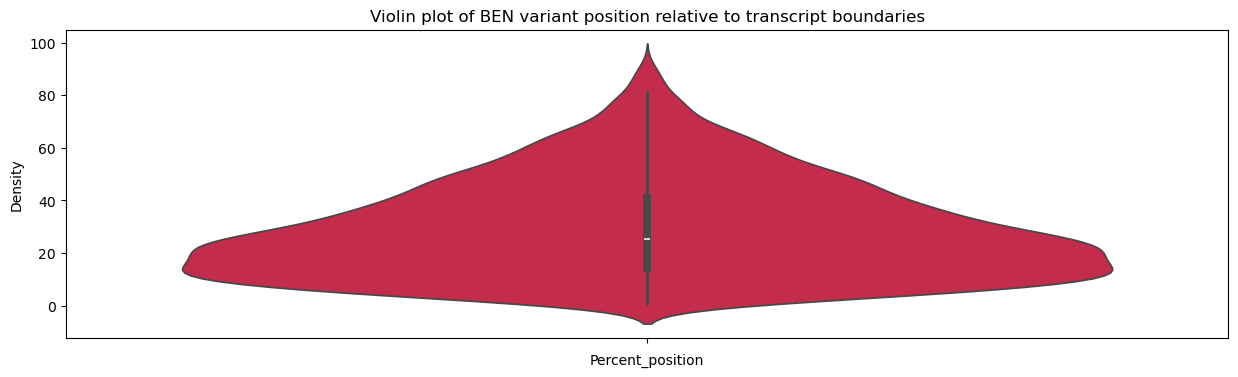

In [40]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=ben_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

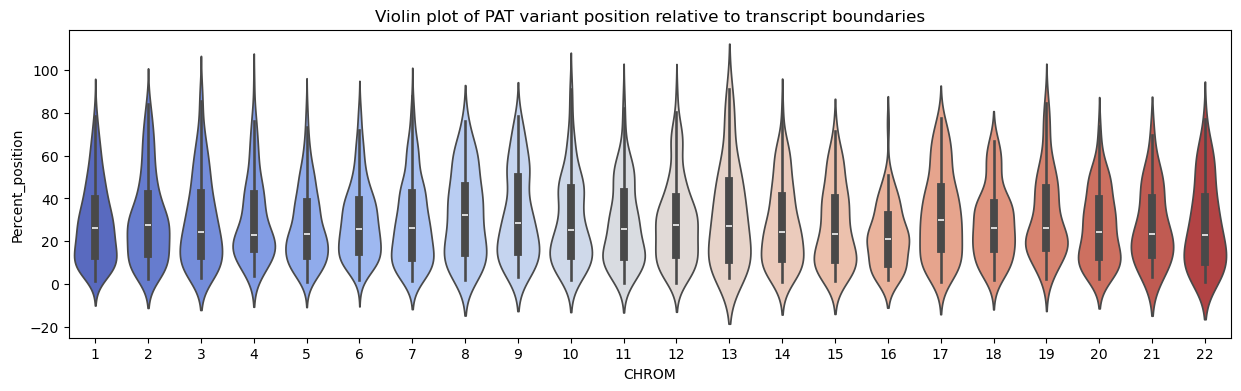

In [41]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

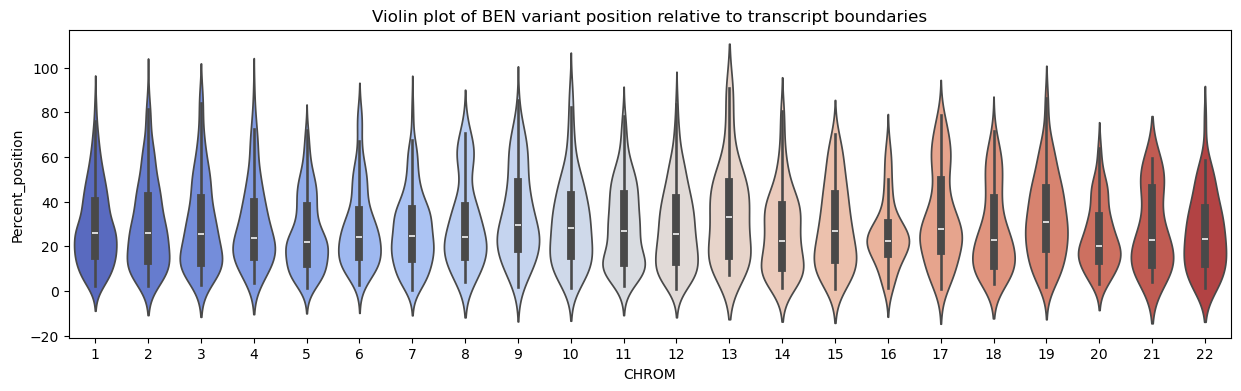

In [42]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

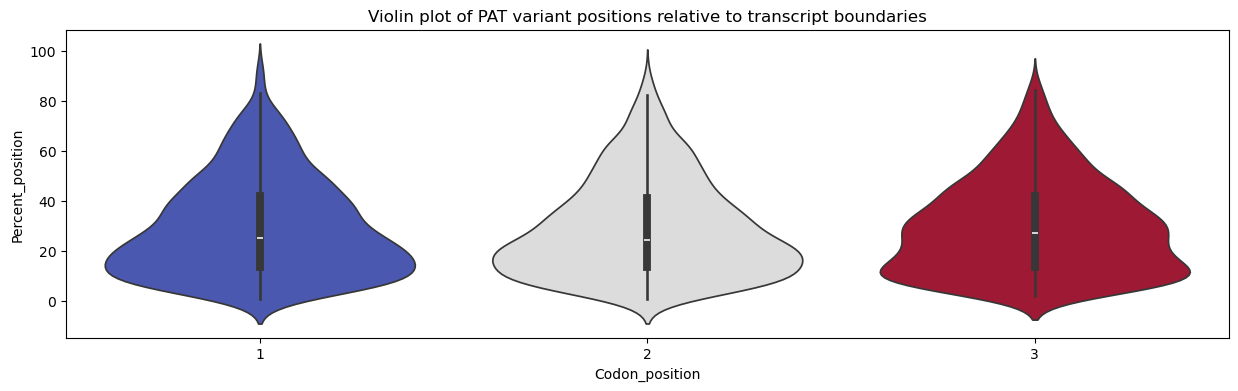

In [43]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

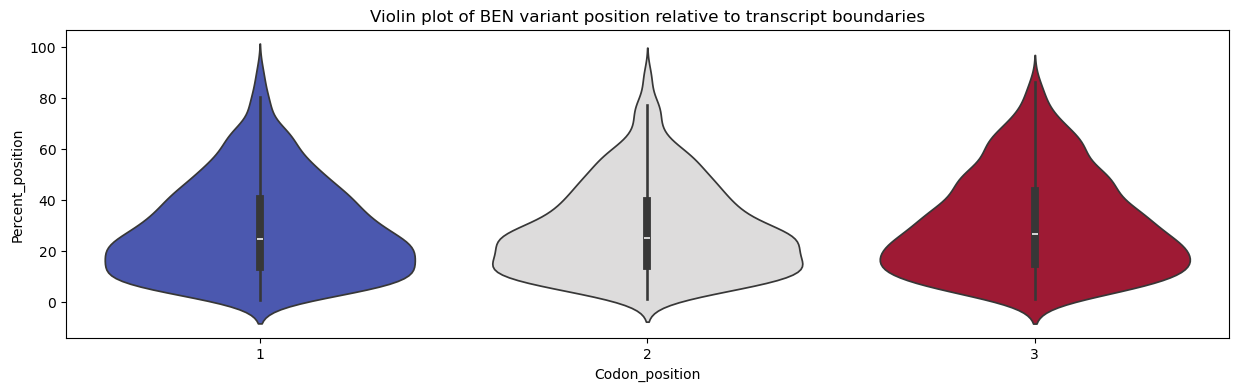

In [44]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

## 5. Get sequence context

Write the context in the corresponding column of the dataframe.

In [45]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

Divide dataframes by variant position in a codon.

In [46]:
ben_nmd_undergo_final_1 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 1].copy()
ben_nmd_undergo_final_2 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 2].copy()
ben_nmd_undergo_final_3 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 3].copy()

In [47]:
pat_nmd_undergo_final_1 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 1].copy()
pat_nmd_undergo_final_2 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 2].copy()
pat_nmd_undergo_final_3 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 3].copy()

Get contexts.

In [48]:
get_context(ben_nmd_undergo_final_1, transcript_fasta, 10, 11)
get_context(ben_nmd_undergo_final_2, transcript_fasta, 11, 10)
get_context(ben_nmd_undergo_final_3, transcript_fasta, 12, 9)

'Contexts have been added to the dataframe!'

In [49]:
get_context(pat_nmd_undergo_final_1, transcript_fasta, 10, 11)
get_context(pat_nmd_undergo_final_2, transcript_fasta, 11, 10)
get_context(pat_nmd_undergo_final_3, transcript_fasta, 12, 9)

'Contexts have been added to the dataframe!'

## 6. Build a sequence logo

In [50]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_undergo_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_undergo_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_undergo_final_3['Context'])

In [51]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_undergo_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_undergo_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_undergo_final_3['Context'])

Text(0.5, 1.0, 'Benign context')

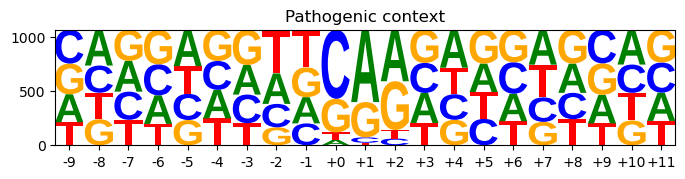

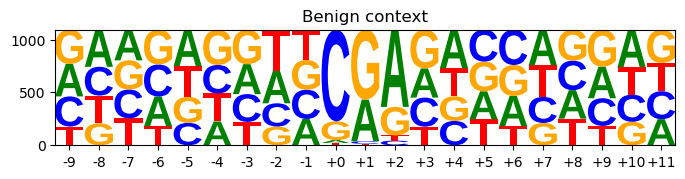

In [52]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')

counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

Text(0.5, 1.0, 'Benign context')

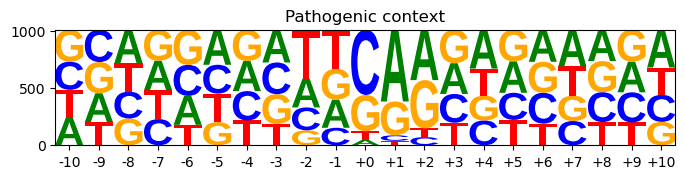

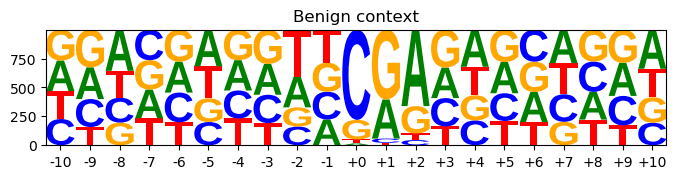

In [53]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
pat_logo = lm.Logo(counts_mat_pat_2, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)
ben_logo = lm.Logo(counts_mat_ben_2, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ben_logo.ax.set_title('Benign context')

Text(0.5, 1.0, 'Benign context')

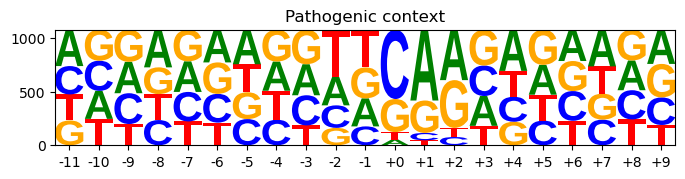

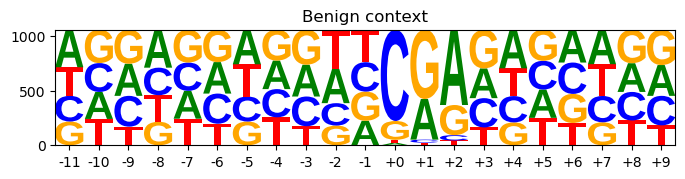

In [54]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
pat_logo = lm.Logo(counts_mat_pat_3, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)
ben_logo = lm.Logo(counts_mat_ben_3, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ben_logo.ax.set_title('Benign context')

## 7. Statistical comparison of positions in contexts

Calculate chi-squares for each position when comparing two matrices (for pathogenic and benign contexts).

In [55]:
chi2_values_1, p_values_1 = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_1, p_values_1)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 9:
        print("==="*25)
    if counter == 10:
        print("==="*25)

Position 0: Chi-square = 10.769451459409602, p-value = 0.013040153620770137
Position 1: Chi-square = 3.9745054637794204, p-value = 0.26423027159187035
Position 2: Chi-square = 1.0324501681746985, p-value = 0.7934006441992937
Position 3: Chi-square = 1.7579662321494738, p-value = 0.6241243855052059
Position 4: Chi-square = 4.364401815242769, p-value = 0.22470895115986142
Position 5: Chi-square = 6.639184994555578, p-value = 0.08433208019419237
Position 6: Chi-square = 0.5485802676016687, p-value = 0.9080960117968525
Position 7: Chi-square = 1.272448529931823, p-value = 0.7356856084081185
Position 8: Chi-square = 17.18821052160071, p-value = 0.0006464614127961924
Position 9: Chi-square = 103.02685719721221, p-value = 3.4719473593611453e-22
Position 10: Chi-square = 194.42336236609646, p-value = 6.761364439328839e-42
Position 11: Chi-square = 108.37504997786806, p-value = 2.454793192331955e-23
Position 12: Chi-square = 7.240653104711965, p-value = 0.0646103250194712
Position 13: Chi-squar

In [56]:
chi2_values_2, p_values_2 = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_2, p_values_2)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 10:
        print("==="*25)
    if counter == 11:
        print("==="*25)

Position 0: Chi-square = 2.1744791297722132, p-value = 0.5369926643995282
Position 1: Chi-square = 14.044936710362864, p-value = 0.002844619934626102
Position 2: Chi-square = 11.406950514186637, p-value = 0.00971708996093364
Position 3: Chi-square = 3.7894818047634717, p-value = 0.28511194607412155
Position 4: Chi-square = 3.394579552184844, p-value = 0.33469436986220624
Position 5: Chi-square = 7.342782940519157, p-value = 0.06173865497607456
Position 6: Chi-square = 1.0802907324594448, p-value = 0.7818339827856778
Position 7: Chi-square = 5.023143439476289, p-value = 0.1701102909351893
Position 8: Chi-square = 8.909865189955891, p-value = 0.030513595099924934
Position 9: Chi-square = 26.030508105523417, p-value = 9.398154576951898e-06
Position 10: Chi-square = 107.98528520833212, p-value = 2.977713893427312e-23
Position 11: Chi-square = 198.1570975057606, p-value = 1.055244732489656e-42
Position 12: Chi-square = 104.69032005624518, p-value = 1.5232447102412765e-22
Position 13: Chi-sq

In [57]:
chi2_values_3, p_values_3 = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_3, p_values_3)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 11:
        print("==="*25)
    if counter == 12:
        print("==="*25)

Position 0: Chi-square = 2.682536119100355, p-value = 0.4432032608416273
Position 1: Chi-square = 1.2739044525455667, p-value = 0.7353388508873173
Position 2: Chi-square = 2.1904280073447016, p-value = 0.5338362153732183
Position 3: Chi-square = 2.9146868387997276, p-value = 0.4049666839013071
Position 4: Chi-square = 2.990928522276734, p-value = 0.3930259353886708
Position 5: Chi-square = 0.8631268141977024, p-value = 0.8343157819793247
Position 6: Chi-square = 4.720841339158749, p-value = 0.1934175409361893
Position 7: Chi-square = 1.5819456835666772, p-value = 0.6634904080682353
Position 8: Chi-square = 0.3035189444932674, p-value = 0.9593653089340225
Position 9: Chi-square = 13.69006875379359, p-value = 0.0033588654113083675
Position 10: Chi-square = 27.422010814007955, p-value = 4.802039342219632e-06
Position 11: Chi-square = 93.72410834803429, p-value = 3.471330444590396e-20
Position 12: Chi-square = 222.21235872833452, p-value = 6.675210262262976e-48
Position 13: Chi-square = 10

In [58]:
positions_1, positions_2, positions_3 = list(range(-9, 12)), list(range(-10, 11)), list(range(-11, 10))

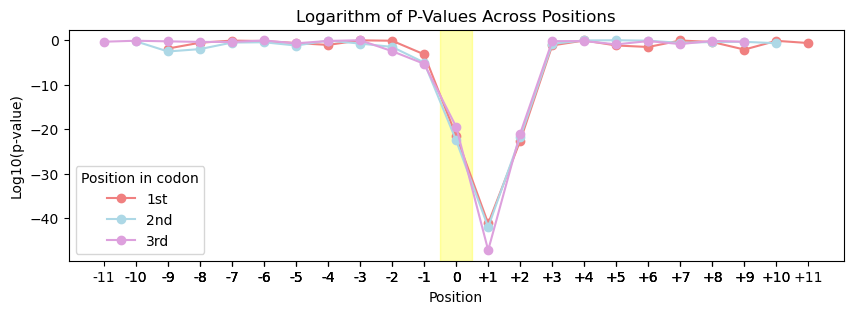

In [59]:
positions_list = [positions_1, positions_2, positions_3]
p_values_list = [p_values_1, p_values_2, p_values_3]

plot_p_values(positions_list, p_values_list)

### Посмотрим на аминокислоты в округе

Краткий пример, что сделала по аминокислотам. Надо будет ещё навести красоту, но как будто бы какая-то фигня вышла всё равно.

In [60]:
transcript_fasta['ENST00000398473'][2209 - 10 : 2209 + 11]  # CAG  5|7 (1 позиция)

>ENST00000398473:2200-2220
ATCAGGGAACAGAGACGCCAG

In [61]:
my_rna = Seq("ATCAGGGAACAGAGACGCCAG")
my_aa = my_rna.translate()
my_aa

Seq('IREQRRQ')

In [62]:
# здесь просто добавила по 90 букв к каждой границе, чтобы вывести в итоге равное количество аминокислот 
# вне зависимости от позиции варианта в кодоне

get_context(ben_nmd_undergo_final_1, transcript_fasta, 10+90, 11+90)
get_context(ben_nmd_undergo_final_2, transcript_fasta, 11+90, 10+90)
get_context(ben_nmd_undergo_final_3, transcript_fasta, 12+90, 9+90)

get_context(pat_nmd_undergo_final_1, transcript_fasta, 10+90, 11+90)
get_context(pat_nmd_undergo_final_2, transcript_fasta, 11+90, 10+90)
get_context(pat_nmd_undergo_final_3, transcript_fasta, 12+90, 9+90)

'Contexts have been added to the dataframe!'

Для аминокислотного контекста я пыталась выровнять количество аминокислот вокруг целевого кодона, учитывая при этом, что у нас датафреймы разделены по позиции. Получилось равное количество остатков для всех датафреймов (67).

**Позиция в кодоне 1:**  

**33 позиция на лого**

In [64]:
pat_nmd_undergo_final_1['AA_context'] = translate_context(pat_nmd_undergo_final_1['Context'])
ben_nmd_undergo_final_1['AA_context'] = translate_context(ben_nmd_undergo_final_1['Context'])

In [65]:
filtered_aa_context_pat_1 = filter_and_convert_to_list(pat_nmd_undergo_final_1['AA_context'])
filtered_aa_context_ben_1 = filter_and_convert_to_list(ben_nmd_undergo_final_1['AA_context'])

Text(0.5, 1.0, 'Benign context')

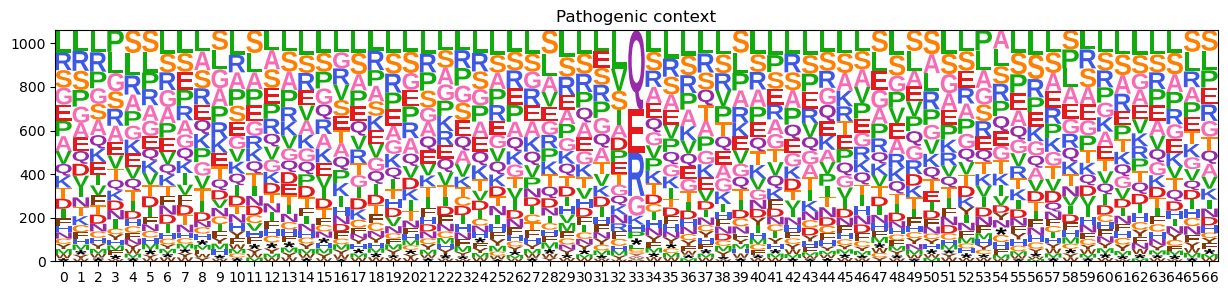

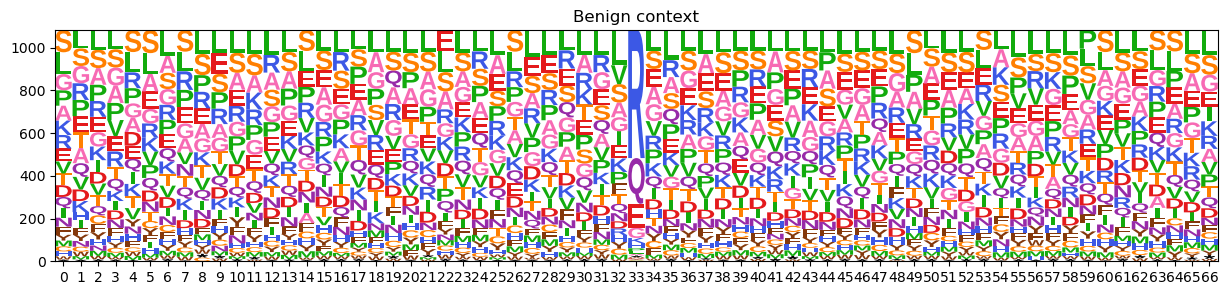

In [66]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_aa_context_pat_1)
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_1 = lm.alignment_to_matrix(filtered_aa_context_ben_1)
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Позиция в кодоне 2:**  
  
**33 позиция на лого**

In [67]:
pat_nmd_undergo_final_2['AA_context'] = translate_context(pat_nmd_undergo_final_2['Context'])
ben_nmd_undergo_final_2['AA_context'] = translate_context(ben_nmd_undergo_final_2['Context'])

In [68]:
filtered_aa_context_pat_2 = filter_and_convert_to_list(pat_nmd_undergo_final_2['AA_context'])
filtered_aa_context_ben_2 = filter_and_convert_to_list(ben_nmd_undergo_final_2['AA_context'])

Text(0.5, 1.0, 'Benign context')

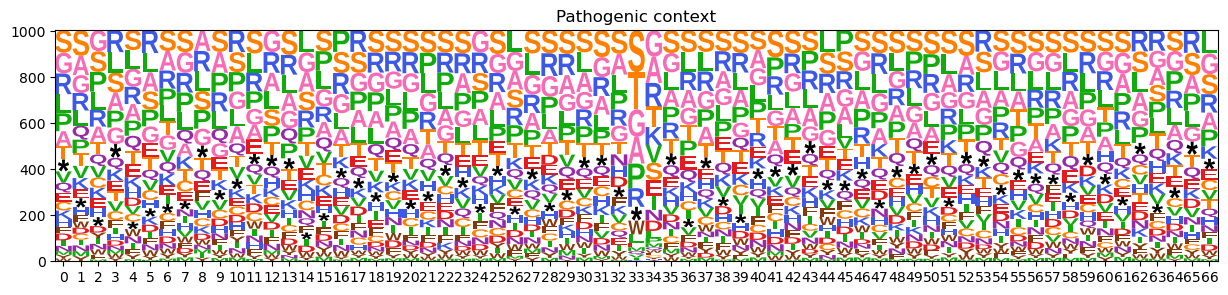

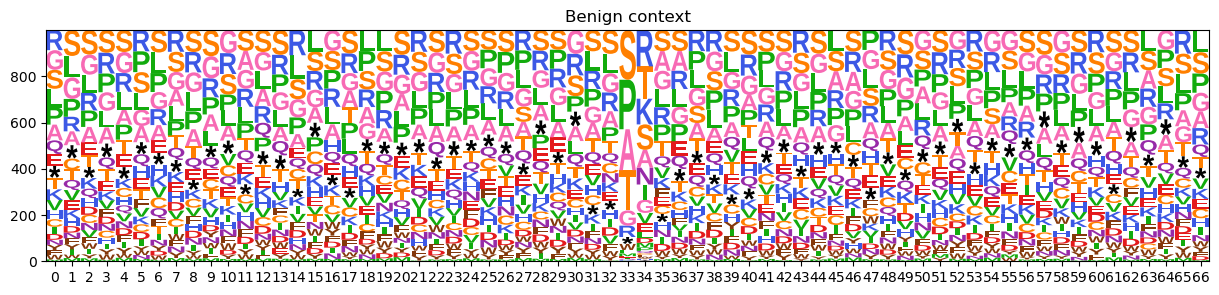

In [69]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_aa_context_pat_2)
pat_logo = lm.Logo(counts_mat_pat_2, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_2 = lm.alignment_to_matrix(filtered_aa_context_ben_2)
ben_logo = lm.Logo(counts_mat_ben_2, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Позиция в кодоне 3:**

**Я в замешательстве -- здесь бОльшие изменения видны не на 33 позиции, как должно быть, а на 34 -_-**

In [70]:
pat_nmd_undergo_final_3['AA_context'] = translate_context(pat_nmd_undergo_final_3['Context'])
ben_nmd_undergo_final_3['AA_context'] = translate_context(ben_nmd_undergo_final_3['Context'])

In [71]:
filtered_aa_context_pat_3 = filter_and_convert_to_list(pat_nmd_undergo_final_3['AA_context'])
filtered_aa_context_ben_3 = filter_and_convert_to_list(ben_nmd_undergo_final_3['AA_context'])

Text(0.5, 1.0, 'Benign context')

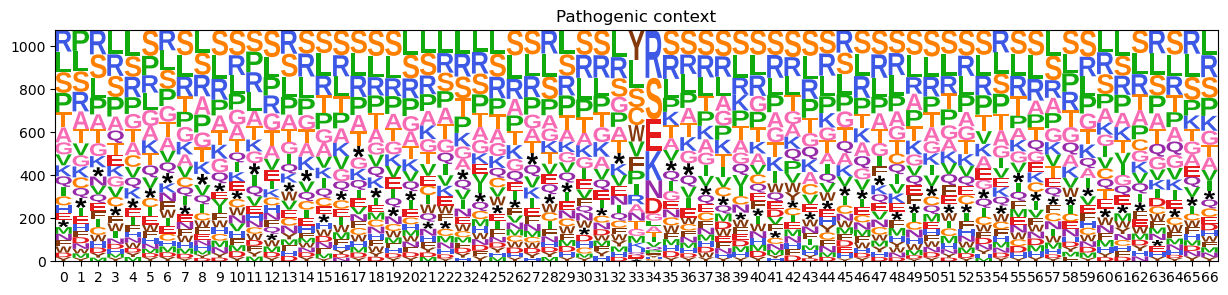

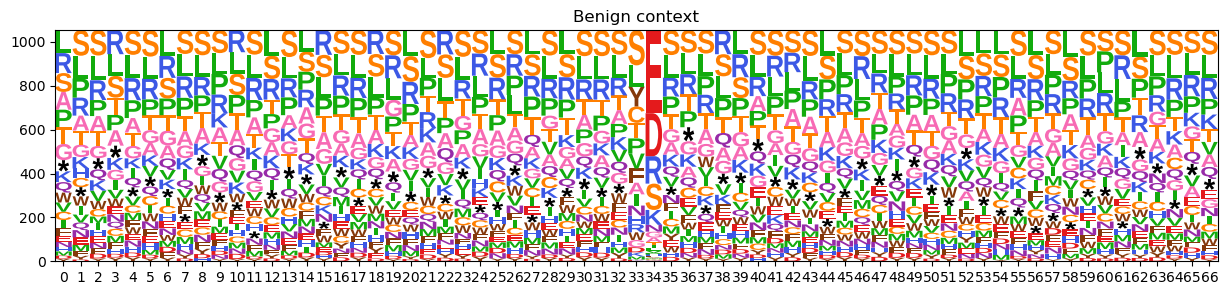

In [72]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_aa_context_pat_3)
pat_logo = lm.Logo(counts_mat_pat_3, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_3 = lm.alignment_to_matrix(filtered_aa_context_ben_3)
ben_logo = lm.Logo(counts_mat_ben_3, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Дальше я попробовала сконкатенировать датафреймы, но в итоге вышло не очень красиво и понятно:**

In [73]:
pat_concatenated_df = pd.concat([pat_nmd_undergo_final_1, pat_nmd_undergo_final_2, pat_nmd_undergo_final_3])
ben_concatenated_df = pd.concat([ben_nmd_undergo_final_1, ben_nmd_undergo_final_2, ben_nmd_undergo_final_3])

In [74]:
filtered_aa_context_pat = filter_and_convert_to_list(pat_concatenated_df['AA_context'])
filtered_aa_context_ben = filter_and_convert_to_list(ben_concatenated_df['AA_context'])

Text(0.5, 1.0, 'Benign context')

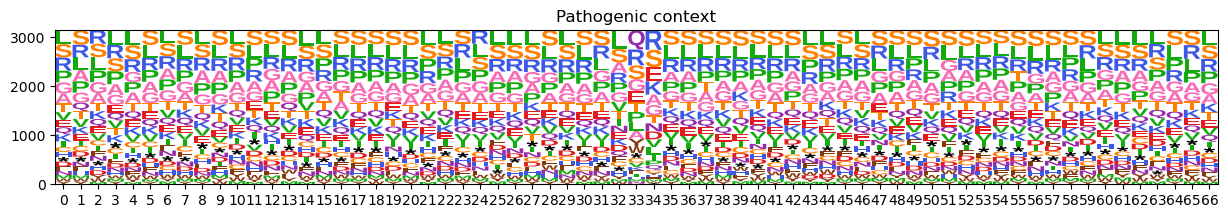

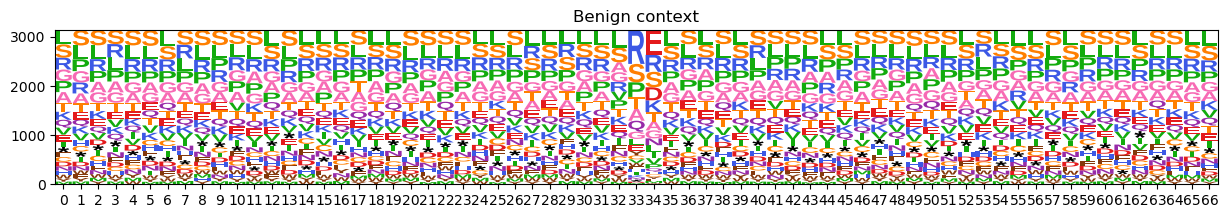

In [75]:
counts_mat_pat = lm.alignment_to_matrix(filtered_aa_context_pat)
pat_logo = lm.Logo(counts_mat_pat, 
                   figsize=(15, 2),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben = lm.alignment_to_matrix(filtered_aa_context_ben)
ben_logo = lm.Logo(counts_mat_ben, 
                   figsize=(15, 2),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')